#  PPO Compensator Controller
Train a PPO compensaor policy using a baseline controller.
### Environments:

#### InvertedPendulum-v2 environment:  
<img src="./notebookImages/invertedpendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="./notebookImages/halfcheetah.png" width="300">

#### Ant environment:
<img src="./notebookImages/ant.png" width="300">

<h2>Imports</h2>

In [1]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv
from ppo import *
import datetime

import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

np.random.seed(0)
torch.manual_seed(2)

%matplotlib inline

<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [3]:
#From original PPO code, is used to setup multiprocessing environments
def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

In [4]:
VISUALIZE = False #Flag to save videos
logging_interval = 10 #Freqeuncy of video saving
COMPENSATION = True #Flag to implement compensation in test function
ACTION_APPEND = True #Flag to indicate to train with appended action or not
EARLY_STOPPING = True #Flag to stop when reward reaches threshold
num_envs = 4 #Number of environments to train across in multiprocessing

Saving figures


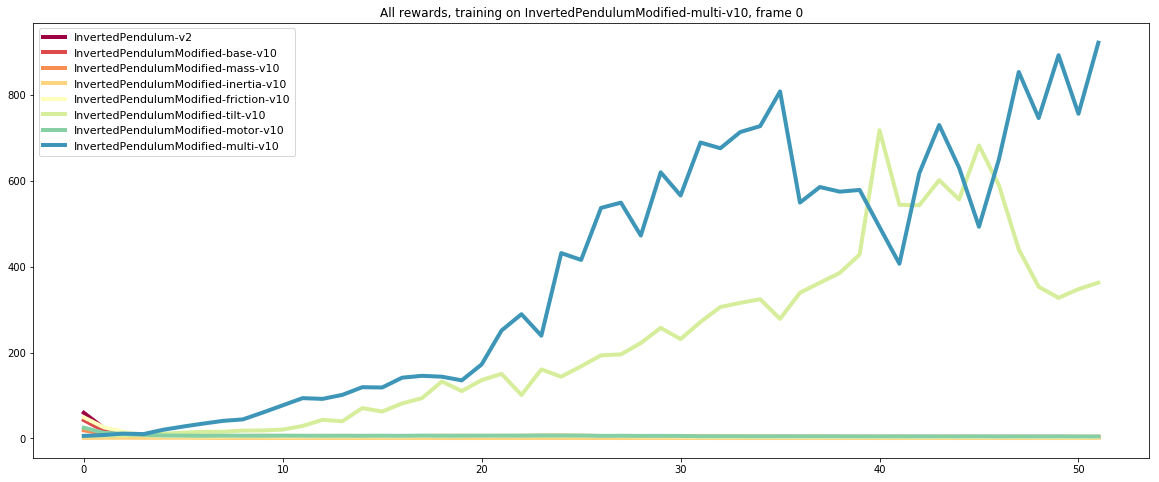

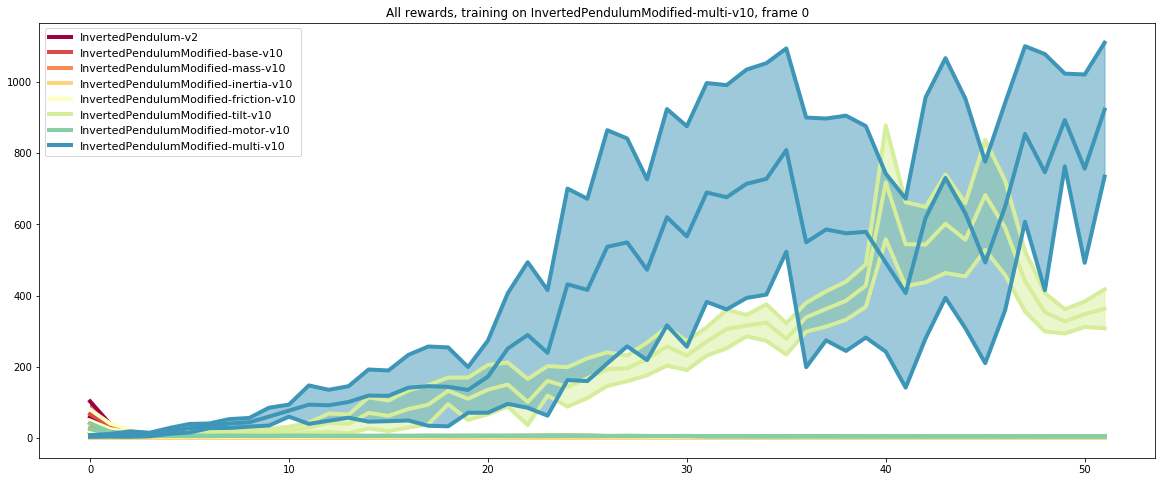

In [5]:
from gym import envs

#env_name = 'InvertedPendulumModified-multi-v10'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'
env_name = 'InvertedPendulumModified-multi-v10'
env_key = "v10" #Unique identifier for custom envs (case sensitive)
policy_env = 'InvertedPendulum-v2'

""""
['InvertedPendulum-v2',
 'InvertedPendulumModified-base-v10',
 'InvertedPendulumModified-mass-v10',
 'InvertedPendulumModified-inertia-v10',
 'InvertedPendulumModified-friction-v10',
 'InvertedPendulumModified-tilt-v10',
 'InvertedPendulumModified-motor-v10',
 'InvertedPendulumModified-multi-v10']
 """

env_ids = [spec.id for spec in envs.registry.all()]
test_env_names = ['InvertedPendulum-v2'] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier

for env_name in test_env_names[1::]:
    training_env_index = test_env_names.index(env_name)

    #Training envs (all the same)
    envs = [make_env(env_name) for i in range(num_envs)]
    envs = SubprocVecEnv(envs)

    #Plotting Results and figures, save weights
    script_dir = os.getcwd()
    time_stamp = datetime.datetime.now().replace(microsecond=0).isoformat()
    results_dir = os.path.join(script_dir, 'compensator_plots/' + env_name + time_stamp + '/')
    baseline_dir = os.path.join(script_dir, 'compensator_weights/' + env_name + time_stamp + '/')

    if not os.path.isdir(results_dir):
        os.mkdir(results_dir)

    if not os.path.isdir(baseline_dir):
        os.mkdir(baseline_dir)

    #Testing on original and new envs
    tests = testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, training_env_index, logging_interval = 10)

    num_inputs  = envs.observation_space.shape[0]
    num_outputs = envs.action_space.shape[0]

    #Hyper params:
    hidden_size      = 64
    lr               = 3e-4
    num_steps        = 2048
    mini_batch_size  = 64
    ppo_epochs       = 10
    threshold_reward = 900

    #Getting right path to baselibe controller weights
    dirs = os.listdir(os.path.join(os.getcwd(), 'baseline_weights/'))
    sub_dir = None
    for names in dirs:
        if policy_env in names:
            sub_dir = names

    weights = os.listdir(os.path.join(os.getcwd(), 'baseline_weights/' + sub_dir))
    for weight in weights:
        if 'endweights' in weight:
            baseline_weights = weight

    ppo_baseline = PPO(num_inputs, num_outputs)
    print("Loading weights from {}".format(os.getcwd() + '/baseline_weights/' + sub_dir + '/' + baseline_weights))
    ppo_baseline.load_weights(os.getcwd() + '/baseline_weights/' + sub_dir + '/' + baseline_weights)
    compensator_test = compensator(num_inputs, num_outputs, ppo_baseline, action_appended = ACTION_APPEND)
    
    max_frames = 2000000
    test_avg_rewards = []
    test_stds = []
    test_itrs = 20
    save_interval = 5 #How often to save weights and figures
    
    state = envs.reset()
    early_stop = False
    ppo_updates = 0
    save_interval = 5
    #Plotting Flags
    indvplots=0
    rewplots=1
    stdplots=1
    which_plts = [indvplots,rewplots,stdplots]

    test_avg_rewards = []
    test_stds = []

    while compensator_test.ppo_compensator.frame_idx < max_frames and not early_stop:

        #collect data
        log_probs, values, states, actions, rewards, masks, next_value = compensator_test.collect_data(envs)

        #compute gae
        returns = compensator_test.ppo_compensator.compute_gae(next_value, rewards, masks, values)

        #update policy
        compensator_test.ppo_compensator.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)

        #plot
        avg_rew = []
        std = []

        #Environment testing and data logging
        #***************************************************************************************
        for env in tests.envs:
            env_rewards = ([tests.test_env(env, compensator_test) for _ in range(test_itrs)])
            avg_rew.append(np.mean(env_rewards))
            std.append(np.std(env_rewards))

        test_avg_rewards.append(avg_rew)
        test_stds.append(std)

        if avg_rew[training_env_index] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
            tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 1)
            early_stop = True
        else:
            if ppo_updates and ppo_updates % save_interval == 0:
                ppo_baseline.save_weights(baseline_dir + env_name + '_weights' + str(ppo_updates/save_interval))
                tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 1, str(ppo_updates/save_interval))
            else:
                tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 0)

        ppo_updates = ppo_updates + 1 #Loop counter
        #***************************************************************************************

    ppo_baseline.save_weights(baseline_dir + env_name + '_compensatorAction_endweights')
    

In [6]:
# from gym import envs

# #env_name = 'InvertedPendulumModified-multi-v10'
# #env_name = "Pendulum-v0"
# #env_name = "HalfCheetah-v2"
# #env_name = 'FetchReach-v1'
# env_name = 'InvertedPendulumModified-multi-v10'
# env_key = "v10" #Unique identifier for custom envs (case sensitive)

# """"
# ['InvertedPendulum-v2',
#  'InvertedPendulumModified-base-v10',
#  'InvertedPendulumModified-mass-v10',
#  'InvertedPendulumModified-inertia-v10',
#  'InvertedPendulumModified-friction-v10',
#  'InvertedPendulumModified-tilt-v10',
#  'InvertedPendulumModified-motor-v10',
#  'InvertedPendulumModified-multi-v10']
#  """

# env_ids = [spec.id for spec in envs.registry.all()]
# test_env_names = ['InvertedPendulum-v2'] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
# training_env_index = test_env_names.index(env_name)

# #Training envs (all the same)
# envs = [make_env(env_name) for i in range(num_envs)]
# envs = SubprocVecEnv(envs)

# #Plotting Results and figures, save weights
# script_dir = os.getcwd()
# time_stamp = datetime.datetime.now().replace(microsecond=0).isoformat()
# results_dir = os.path.join(script_dir, 'compensator_plots/' + env_name + time_stamp + '/')
# baseline_dir = os.path.join(script_dir, 'compensator_weights/' + env_name + time_stamp + '/')

# if not os.path.isdir(results_dir):
#     os.mkdir(results_dir)
    
# if not os.path.isdir(baseline_dir):
#     os.mkdir(baseline_dir)

# #Testing on original and new envs
# tests = testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, training_env_index, logging_interval = 10)

In [7]:
# num_inputs  = envs.observation_space.shape[0]
# num_outputs = envs.action_space.shape[0]

# #Hyper params:
# hidden_size      = 64
# lr               = 3e-4
# num_steps        = 2048
# mini_batch_size  = 64
# ppo_epochs       = 10
# threshold_reward = 900

# #Getting right path to baselibe controller weights
# dirs = os.listdir(os.path.join(os.getcwd(), 'baseline_weights/'))
# sub_dir = None
# for names in dirs:
#     if env_name in names:
#         sub_dir = names
    
# weights = os.listdir(os.path.join(os.getcwd(), 'baseline_weights/' + sub_dir))
# for weight in weights:
#     if 'endweights' in weight:
#         baseline_weights = weight

# ppo_baseline = PPO(num_inputs, num_outputs)
# ppo_baseline.load_weights(os.getcwd() + '/baseline_weights/' + sub_dir + '/' + baseline_weights)
# compensator_test = compensator(num_inputs, num_outputs, ppo_baseline, action_appended = ACTION_APPEND)

In [8]:
# weights_dir = os.path.join(os.getcwd(), 'baseline_weights/')
# dirs = os.listdir(os.path.join(os.getcwd(), 'baseline_weights/'))
# sub_dir = None
# for names in dirs:
#     if env_name in names:
#         sub_dir = names
    
# weights = os.listdir(os.path.join(os.getcwd(), 'baseline_weights/' + sub_dir))
# for weight in weights:
#     if 'endweights' in weight:
#         baseline_weights = weight
# baseline_weights

In [9]:
# max_frames = 2000000
# test_avg_rewards = []
# test_stds = []
# test_itrs = 20
# save_interval = 5 #How often to save weights and figures

## Train compensator with action appended

In [10]:
# state = envs.reset()
# early_stop = False
# ppo_updates = 0
# save_interval = 5
# #Plotting Flags
# indvplots=0
# rewplots=1
# stdplots=1
# which_plts = [indvplots,rewplots,stdplots]

# test_avg_rewards = []
# test_stds = []

# while compensator_test.ppo_compensator.frame_idx < max_frames and not early_stop:

#     #collect data
#     log_probs, values, states, actions, rewards, masks, next_value = compensator_test.collect_data(envs)
    
#     #compute gae
#     returns = compensator_test.ppo_compensator.compute_gae(next_value, rewards, masks, values)
    
#     #update policy
#     compensator_test.ppo_compensator.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
#     #plot
#     avg_rew = []
#     std = []
    
#     #Environment testing and data logging
#     #***************************************************************************************
#     for env in tests.envs:
#         env_rewards = ([tests.test_env(env, compensator_test) for _ in range(test_itrs)])
#         avg_rew.append(np.mean(env_rewards))
#         std.append(np.std(env_rewards))

#     test_avg_rewards.append(avg_rew)
#     test_stds.append(std)

#     if avg_rew[training_env_index] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
#         tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 1)
#         early_stop = True
#     else:
#         if ppo_updates and ppo_updates % save_interval == 0:
#             ppo_baseline.save_weights(baseline_dir + env_name + '_weights' + str(ppo_updates/save_interval))
#             tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 1, str(ppo_updates/save_interval))
#         else:
#             tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 0)
            
#     ppo_updates = ppo_updates + 1 #Loop counter
#     #***************************************************************************************

# ppo_baseline.save_weights(baseline_dir + env_name + '_compensatorAction_endweights')